# Project 4 - NLP with Twitter Sentiments

## Business Understanding
Businesses often wish to get feedback on their products, however getting direct feedback usually requires that someone takes time to write something like a product review. People informally talk about their lives in social media like Twitter and could be a source of informal product feedback. Being able to automatically capture product sentiment, like if a product was being received positively or negatively, could gain companies insight into how their product is being perceived.

In [1]:
import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, recall_score
from imblearn.over_sampling import SMOTE

## Functions
Below are the functions created for repetetive tasks

In [3]:
def preprocess(column):
    '''
    Takes a single-column dataframe and return a list of the cleaned text.
    
    Parameters: 
    column: Single column of dataframe with rows of strings
    
    Returns:
    cleanedtext: List of cleaned strings
    '''
    acceptable = re.compile('[a-zA-Z @]') # regex expression to keep letters and handles

    # make a list of the text that fits with regex above
    cleanedtext = []
    for text in column:
        p = ''.join(acceptable.findall(text)).lower()
        cleanedtext.append(p)
    
    return cleanedtext

In [4]:
# Function to look at top words for each dataset
def top_words(col, n):
    '''
    Takes a dataframe column and returns a list of the top words
    
    Parameters: 
    col: Single column of dataframe with rows of strings
    n: how many words to return
    
    Returns:
    top_words: List of top n words
    
    '''
    all_words = []
    for text in col:
        all_words += [w for w in text]
    freqdist = FreqDist(all_words)
    top_words = freqdist.most_common(n)
    return top_words

In [5]:
def word_cloud(word_list, n=20):
    '''
    Generate word clouds using words of a given list.
    
    Parameters: 
    tops: list of ranked word
    
    Returns:
    word cloud visualization
    '''
    tops = ' '.join([x[0] for x in top_words(word_list, n)])

    wordcloud = WordCloud(width = 1000, 
                          height = 600, 
                          random_state=1, 
                          background_color='grey', 
                          collocations=False, 
                          stopwords = STOPWORDS
                         ).generate(tops)
    #Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    plt.show()

In [6]:
def remove_words(col, to_remove):
    '''
    Takes a tokenized df column and a list of words and returns the tokens with the words removed.
    
    Parameters: 
    df: Single column of dataframe with rows of strings
    to_remove: List of words to be removed from strings
    
    Returns: 
    cleaned: List of strings with desired words removed
    
    '''
    cleaned = []
    for text in col:
        cleaned.append([w for w in text if w not in to_remove])
    return cleaned

In [7]:
def remove_singles(col):
    '''
    Remove words that appear only once in a list of strings.
    
    Parameters: 
    col: Single column of dataframe with rows of strings
    
    Returns: 
    list_of_sentences: List of strings with single words removed
    
    '''
    all_words = []
    for text in col:
        all_words += [w for w in text]
    freqdist = FreqDist(all_words)
    removable_words = ['sxsw', 'rt', 'link', 'quot']
    single_words = [x[0] for x in freqdist.most_common() if x[1]==1]
    removable_words += single_words 
    list_of_strings = remove_words(col, removable_words)
    list_of_sentences = [' '.join(q) for q in list_of_strings]
    return list_of_sentences

In [8]:
def train_and_predict(model, Xy):
    '''
    Given a model and train and test data, function fits the model and returns predicted values.
    
    Parameters: 
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    Xy: updated Xy object with X & y prediction data (y_hat_train and y_hat_test)
    
    '''
    model.fit(Xy.X_train, Xy.y_train)
    
    # Make predictions for test data
    Xy.y_hat_train = model.predict(Xy.X_train)
    
    # Make predictions for test data
    Xy.y_hat_test = model.predict(Xy.X_test)
    
    return Xy

In [9]:
def run_grid_search(params, model, Xy):
    '''
    Takes in parameters, model, and test train data, runs grid search, and 
    returns updated model and test train data.
    
    Parameters: 
    params: dict with parameters for grid search
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    gs: object containing updated model
    Xy: object with test train data
    '''
    gs = GridSearchCV(model, params, scoring='f1_macro', cv=None, n_jobs=1)
    gs = gs.fit(Xy.X_train, Xy.y_train)
    best_parameters = gs.best_params_

    print('Grid Search found the following optimal parameters: ')
    for param_name in sorted(best_parameters.keys()):
        print('%s: %r' % (param_name, best_parameters[param_name]))

    # Make predictions for test data
    Xy.y_hat_train = gs.predict(Xy.X_train)
    
    # Make predictions for test data
    Xy.y_hat_test = gs.predict(Xy.X_test)
    
    return gs, Xy

In [10]:
def model_scores(model, Xy):
    '''
    Takes model and test train data objects and generates scores and confusion matrix.
    
    Parameters: 
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    printed text and visualizations
    '''
    # Caclulate accuracy for test data
    train_accuracy = accuracy_score(Xy.y_train, Xy.y_hat_train)
    print('Training Accuracy: {:.4}%'.format(train_accuracy * 100))

    # Caclulate accuracy for test data
    test_accuracy = accuracy_score(Xy.y_test, Xy.y_hat_test)
    print('Test Accuracy: {:.4}%\n'.format(test_accuracy * 100))
    
    # Caclulate F1 for train data
    train_f1 = f1_score(Xy.y_train, Xy.y_hat_train, pos_label='negative')
    print('Training F1 Score: {:.4}%'.format(train_f1 * 100))

    # Calculate F1 for test data
    test_f1 = f1_score(Xy.y_test,Xy. y_hat_test, pos_label='negative')
    print('Test F1 Score: {:.4}%'.format(test_f1 * 100))

    # Plot confusion matrix
    print('\nConfusion Matrix for test data')
    plot_confusion_matrix(model, X=Xy.X_test, y_true=Xy.y_test)
    plt.show()

## Data Understanding
The data used for this project is from data.world, and a copy can be accessed [here](https://data.world/crowdflower/brands-and-product-emotions).

The data used for this project is a collection of tweets that have been classified by a human as to whether they are positive, negative, neutral, or if the sentiment is unknown. Further, the subject of the tweets center around Apple or Android products.

In [11]:
# Load data and take a first look
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', 
                   encoding='ansi')
df = pd.DataFrame(data)
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


## Text Preprocessing
Before modeling, the text needs to be cleaned and processed so that it is suitable for modeling. I'll take out undesired 
characters and rows from the data, tokenize, and then ultimately vectorize the text.

In [12]:
# rename columns to shorter names and look at info
df = df.rename(columns={'emotion_in_tweet_is_directed_at':'subject',
                        'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text    9092 non-null object
subject       3291 non-null object
sentiment     9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [13]:
# get a list of the sentiment categories
sentiments = list(set(df['sentiment']))
sentiments

['Positive emotion',
 'No emotion toward brand or product',
 "I can't tell",
 'Negative emotion']

In [14]:
# rename the categories to simpler labels
df['sentiment'] = df['sentiment'].replace(to_replace='Positive emotion', value ='positive')
df['sentiment'] = df['sentiment'].replace(to_replace='Negative emotion', value ='negative')
df['sentiment'] = df['sentiment'].replace(to_replace='''I can't tell''', value ='unknown')
df['sentiment'] = df['sentiment'].replace(to_replace='No emotion toward brand or product', value ='neutral')

In [15]:
# drop rows without tweet text and fill renaming nan values with 'none'
df = df.dropna(subset=['tweet_text'])
df = df.fillna('none')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text    9092 non-null object
subject       9092 non-null object
sentiment     9092 non-null object
dtypes: object(3)
memory usage: 284.1+ KB


In [16]:
# make a n ew column of the clean text
df['cleaned_text'] = preprocess(df['tweet_text'])
df

,tweet_text,subject,sentiment,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,positive,ipad everywhere sxsw link
9089,"Wave, buzz... RT @mention We interrupt your re...",none,neutral,wave buzz rt @mention we interrupt your regula...
9090,"Google's Zeiger, a physician never reported po...",none,neutral,googles zeiger a physician never reported pote...
9091,Some Verizon iPhone customers complained their...,none,neutral,some verizon iphone customers complained their...


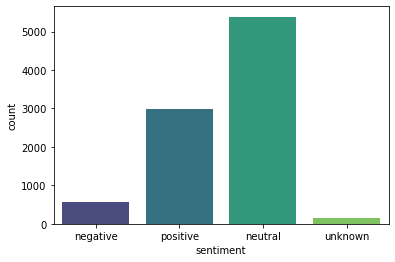

In [17]:
# Look at the counts for each category
ax = sns.countplot(x='sentiment', data=df, palette='viridis')

Looking at the above chart, we see that we do have a bit of an imbalance, with a large majority of the classes in the neutral and positive categories. To hone in classifying an actual sentiment, I removed the unknown and neutral classes, since the unknown class does not provide useful information, and the neutral class does not capture a sentiment one way or another.

In [18]:
# drop unknown sentiments
df = df[df['sentiment'] != 'unknown']
df = df[df['sentiment'] != 'neutral']

In [19]:
# tokenize the tweet text
tt = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
df['tokenized_text'] = df['cleaned_text'].apply(tt.tokenize)

In [20]:
# reset the index and review tokenized text
df = df.reset_index(drop=True)
df

,tweet_text,subject,sentiment,cleaned_text,tokenized_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...,"[i, have, a, g, iphone, after, hrs, tweeting, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...,"[know, about, awesome, ipadiphone, app, that, ..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...,"[can, not, wait, for, ipad, also, they, should..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...,"[i, hope, this, years, festival, isnt, as, cra..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...,"[great, stuff, on, fri, sxsw, marissa, mayer, ..."
...,...,...,...,...,...
3543,@mention your PR guy just convinced me to swit...,iPhone,positive,@mention your pr guy just convinced me to swit...,"[your, pr, guy, just, convinced, me, to, switc..."
3544,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,positive,quotpapyrussort of like the ipadquot nice lol...,"[quotpapyrussort, of, like, the, ipadquot, nic..."
3545,Diller says Google TV &quot;might be run over ...,Other Google product or service,negative,diller says google tv quotmight be run over by...,"[diller, says, google, tv, quotmight, be, run,..."
3546,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,positive,ive always used camera for my iphone bc it has...,"[ive, always, used, camera, for, my, iphone, b..."


In [21]:
# remove English language stopwords and add revisions to new column
stopwords_list = stopwords.words('english')
df['stopped_tokens'] = remove_words(df['tokenized_text'], stopwords_list)

In [22]:
df.head()

,tweet_text,subject,sentiment,cleaned_text,tokenized_text,stopped_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...,"[i, have, a, g, iphone, after, hrs, tweeting, ...","[g, iphone, hrs, tweeting, riseaustin, dead, n..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...,"[know, about, awesome, ipadiphone, app, that, ...","[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...,"[can, not, wait, for, ipad, also, they, should...","[wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...,"[i, hope, this, years, festival, isnt, as, cra...","[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...,"[great, stuff, on, fri, sxsw, marissa, mayer, ...","[great, stuff, fri, sxsw, marissa, mayer, goog..."


In [23]:
# Lemmatize stopped tokens and create new column with lemmed words
lemmatizer = WordNetLemmatizer()
lemmed_tokens=[]
for text in df['stopped_tokens']:
    lemmed_tokens.append([lemmatizer.lemmatize(w) for w in text]) 
df['lemmed_tokens'] = lemmed_tokens

In [24]:
df.head()

,tweet_text,subject,sentiment,cleaned_text,tokenized_text,stopped_tokens,lemmed_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...,"[i, have, a, g, iphone, after, hrs, tweeting, ...","[g, iphone, hrs, tweeting, riseaustin, dead, n...","[g, iphone, hr, tweeting, riseaustin, dead, ne..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...,"[know, about, awesome, ipadiphone, app, that, ...","[know, awesome, ipadiphone, app, youll, likely...","[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...,"[can, not, wait, for, ipad, also, they, should...","[wait, ipad, also, sale, sxsw]","[wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...,"[i, hope, this, years, festival, isnt, as, cra...","[hope, years, festival, isnt, crashy, years, i...","[hope, year, festival, isnt, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...,"[great, stuff, on, fri, sxsw, marissa, mayer, ...","[great, stuff, fri, sxsw, marissa, mayer, goog...","[great, stuff, fri, sxsw, marissa, mayer, goog..."


In [25]:
# make list of top words for each sentiment
df_pos = df[df['sentiment']=='positive']['lemmed_tokens']
df_neg = df[df['sentiment']=='negative']['lemmed_tokens']
to_remove = ['sxsw', 'link', 'rt', 'amp', 'apple', 'google', 'iphone', 'ipad', 'android', 'store', 'app', 'new', 'austin']
df_pos = remove_words(df_pos, to_remove)
df_neg = remove_words(df_neg, to_remove)

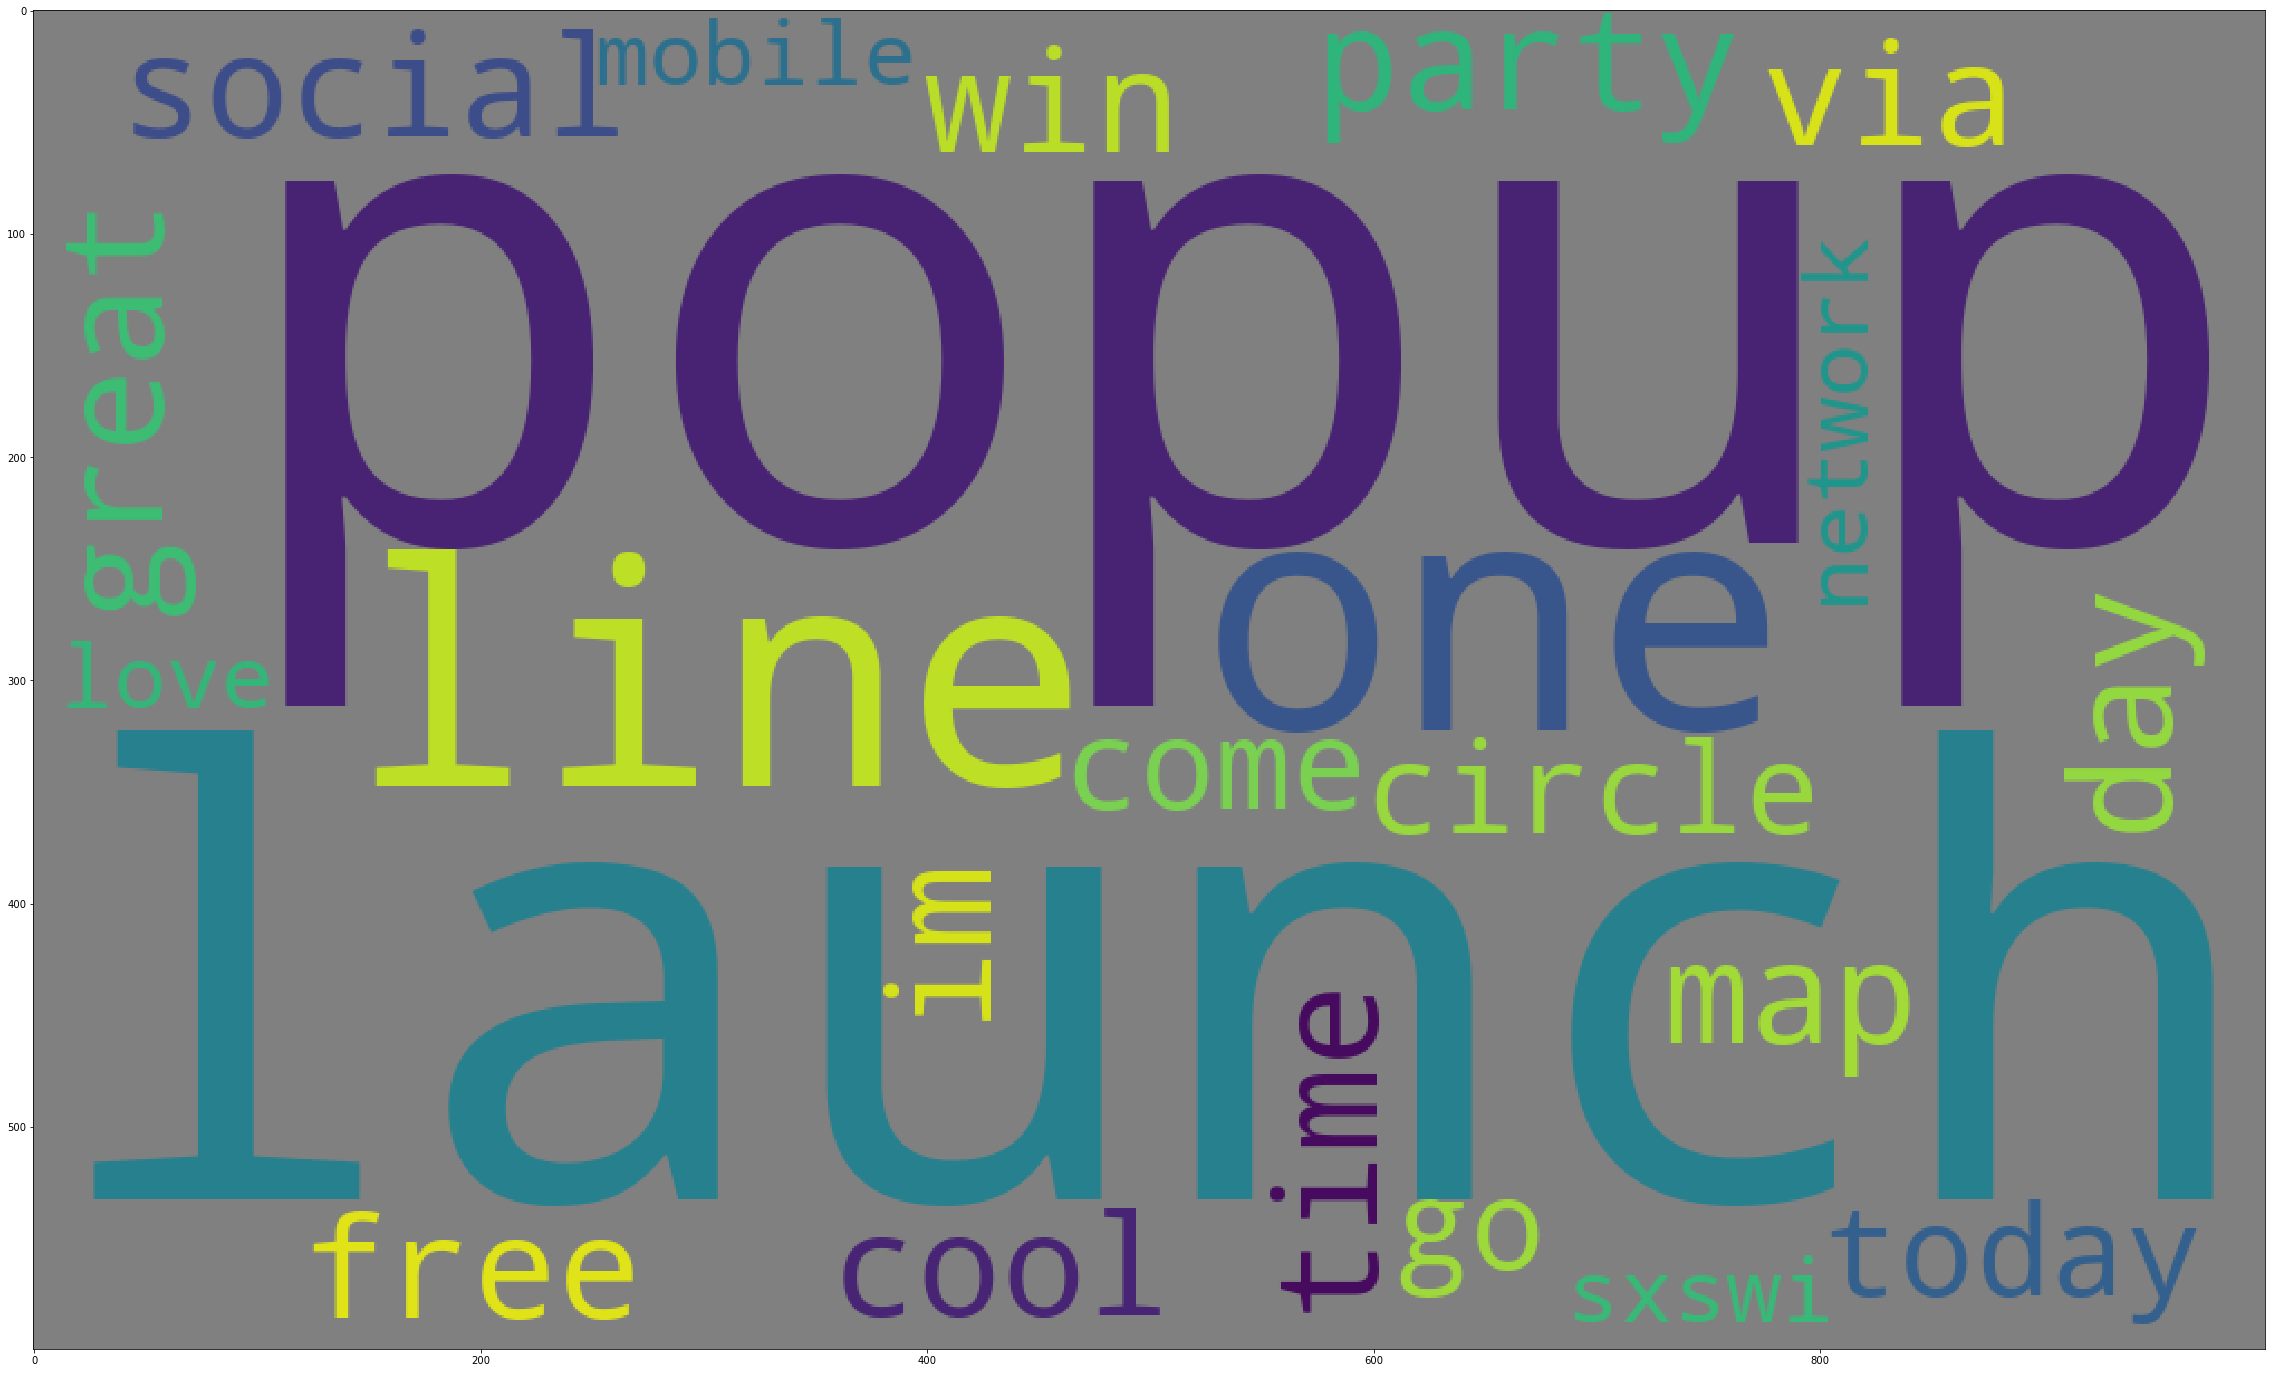

In [26]:
# top words for positive tweets
word_cloud(df_pos, 25)

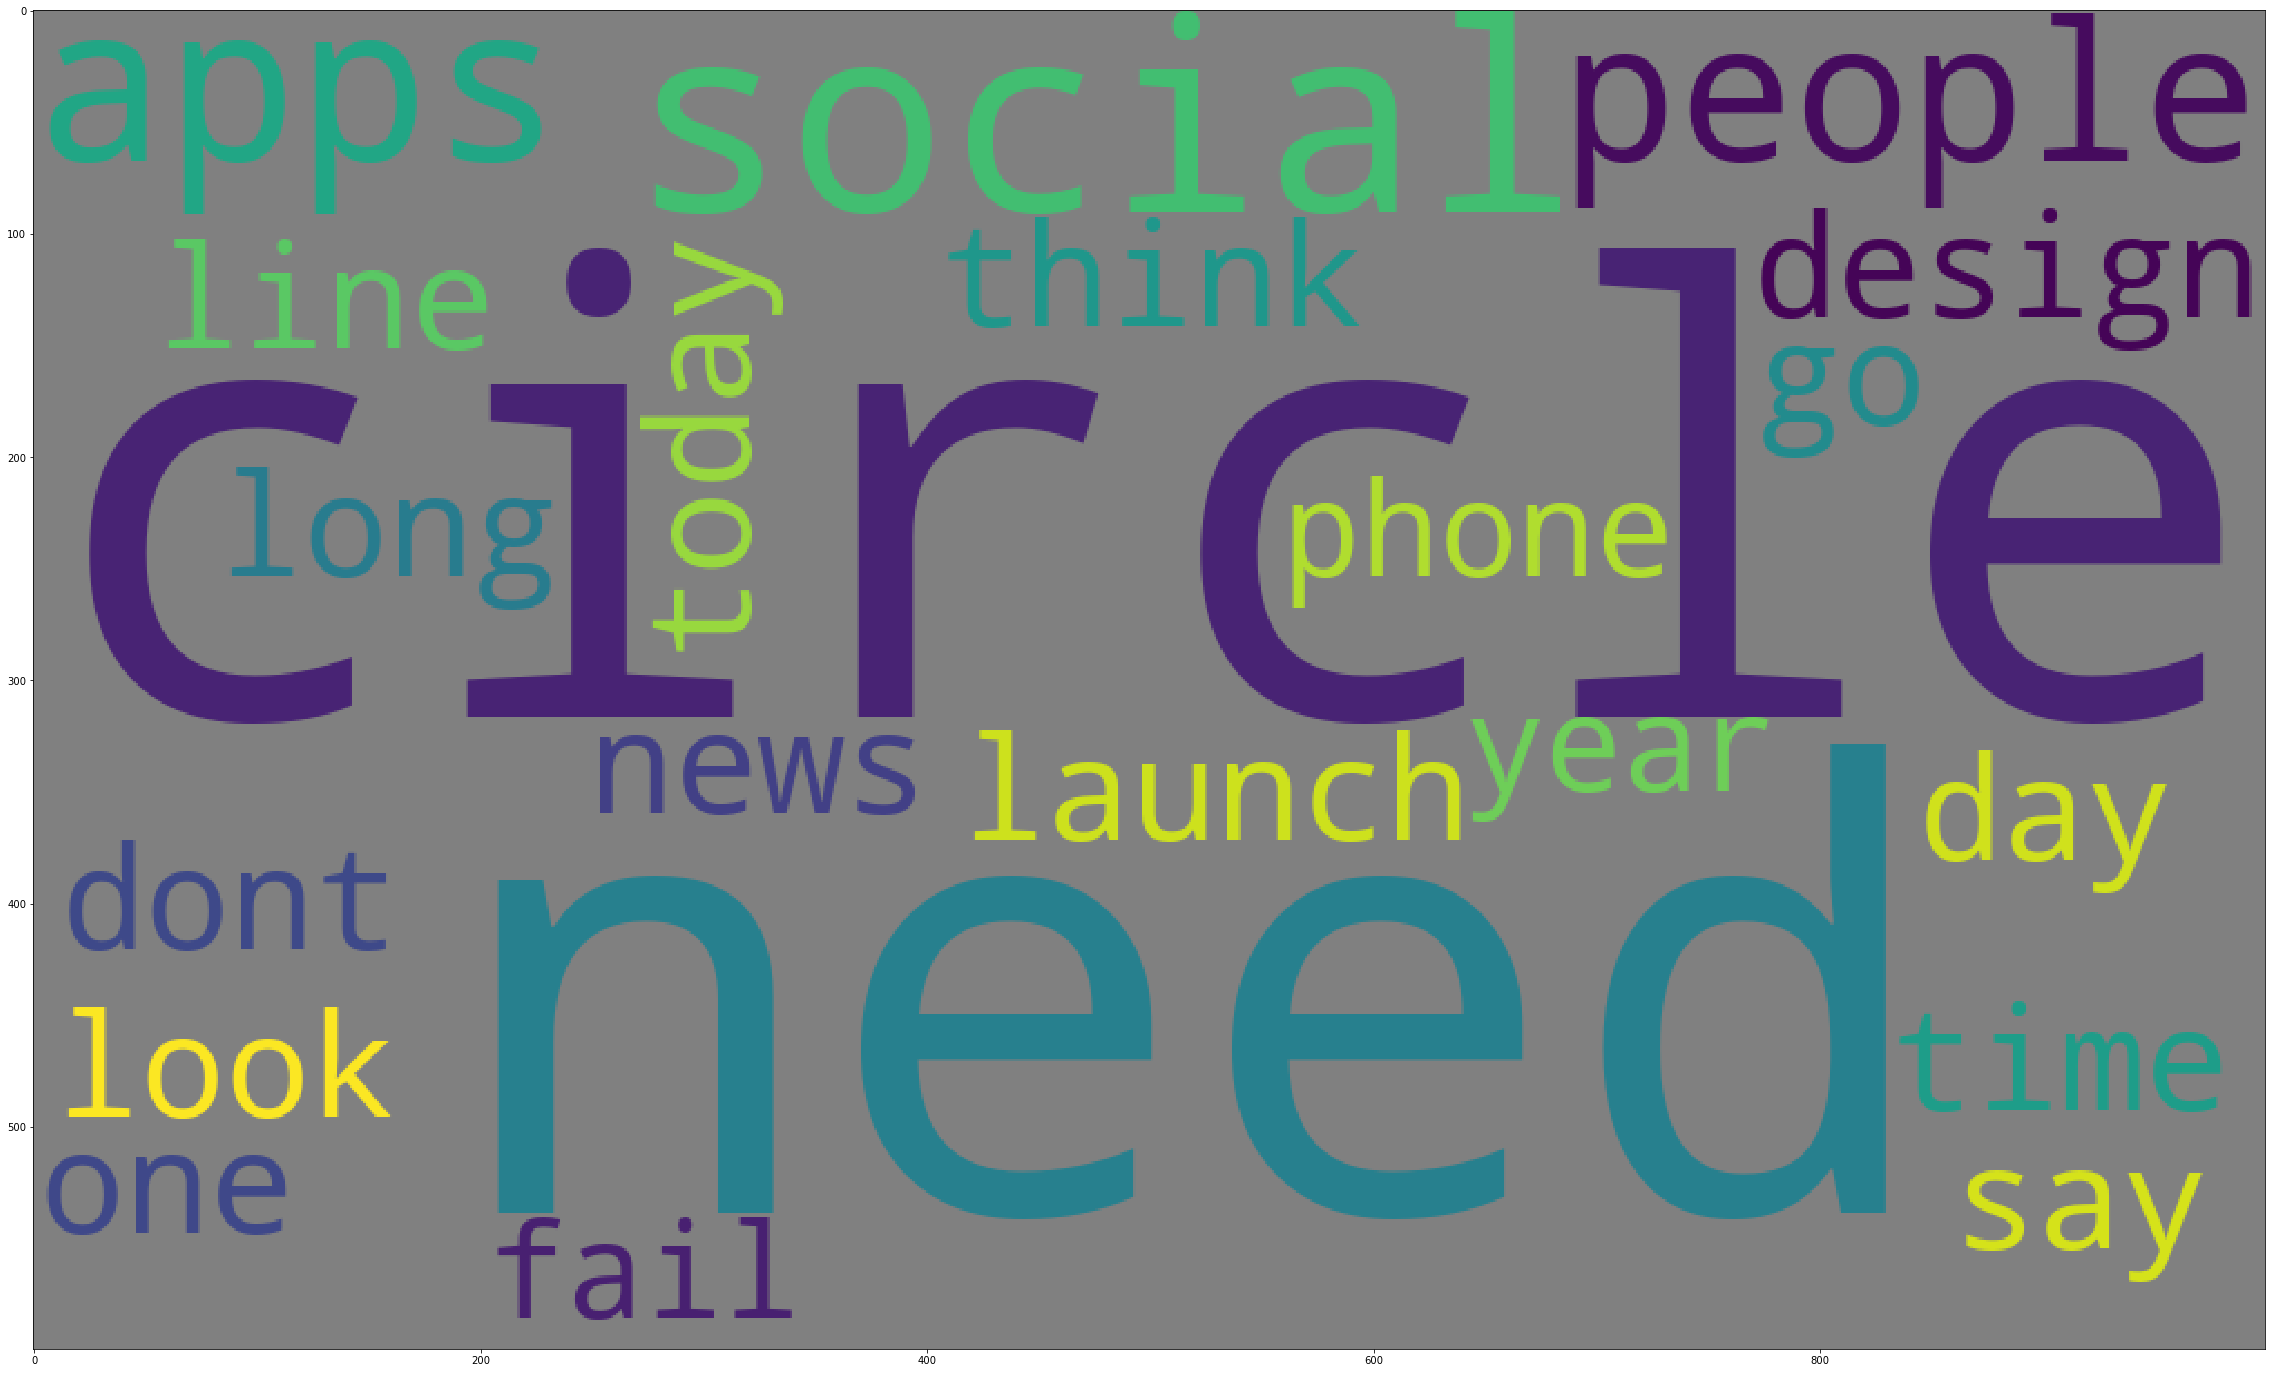

In [27]:
# top words for negative tweets
word_cloud(df_neg, 25)

Cleaning is now done. Now to prepare text for modeling. 

In [28]:
# Create object of test and train data 
X = df['lemmed_tokens']
y = df['sentiment']
class Xy:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [29]:
# Remove single words from current dataframe
Xy.X_train = remove_singles(Xy.X_train)
Xy.X_test = remove_singles(Xy.X_test)

In [30]:
# Created vectorized datset of both train and test data
vec = CountVectorizer(ngram_range=(1,2))

# fit vectorizer on training data
X_train_transformed = vec.fit_transform(Xy.X_train)
Xy.X_train = pd.DataFrame(X_train_transformed.toarray(), columns = vec.get_feature_names())

# fit vectorizer on test data using train transform
X_test_transformed = vec.transform(Xy.X_test)
Xy.X_test = pd.DataFrame(X_test_transformed.toarray(), columns = vec.get_feature_names())

In [31]:
# Use SMOTE to deal with imbalance
print("Before OverSampling, counts of label 'negative': {}".format(sum(Xy.y_train == 'negative')))
print("Before OverSampling, counts of label 'positive': {} \n".format(sum(Xy.y_train == 'positive')))

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(Xy.X_train, Xy.y_train)

print("After OverSampling, counts of label 'negative': {}".format(sum(y_train_res == 'negative')))
print("After OverSampling, counts of label 'positive': {}".format(sum(y_train_res == 'positive')))

Xy.X_train = X_train_res
Xy.y_train = y_train_res

Before OverSampling, counts of label 'negative': 455
Before OverSampling, counts of label 'positive': 2383 

After OverSampling, counts of label 'negative': 2383
After OverSampling, counts of label 'positive': 2383


## Model 1 - Logistic Regression
Using the vectorized data, first try to see how Logistic Regression performs. 

Training Accuracy: 98.89%
Test Accuracy: 80.7%

Training F1 Score: 98.89%
Test F1 Score: 49.07%

Confusion Matrix for test data


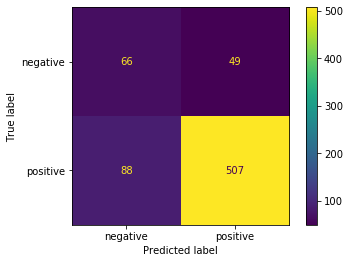

In [32]:
# Initiate the model
logreg = LogisticRegression(random_state=42, n_jobs=1)

# Fit the model and get predictions
lr_Xy = train_and_predict(logreg, Xy)

# Evaluate model
model_scores(logreg, lr_Xy)

Summary: The positive class was predicted accurately, however the negative class was only slightly better than guessing.

## Model 1b - Logistic Regression - Optimized

In this iteration, I want to try to get a better performance from the logistic regression model.

Grid Search found the following optimal parameters: 
C: 10
class_weight: 'None'
max_iter: 200
Training Accuracy: 99.66%
Test Accuracy: 81.41%

Training F1 Score: 99.66%
Test F1 Score: 52.17%

Confusion Matrix for test data


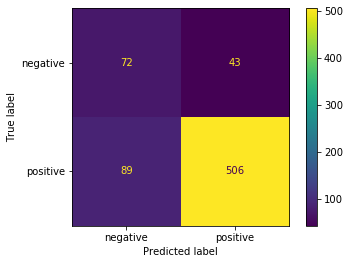

In [33]:
# Get best parameters via grid search
params_lr = {
    'C':[10, 1, .1, .01],
    'class_weight':['None', 'balanced'],
    'max_iter':[200]
    }
(lr_gs, lr_gs_Xy) = run_grid_search(params_lr, logreg, Xy)

# Evaluate model
model_scores(lr_gs, lr_gs_Xy)

Summary: Some improvement to predicting the negative class but still not much better than guessing.

## Model 2 - Decision Tree Classifier

Changing gears, I wanted to see how a decision tree classifier would perform.

Training Accuracy: 99.69%
Test Accuracy: 75.07%

Training F1 Score: 99.69%
Test F1 Score: 45.87%

Confusion Matrix for test data


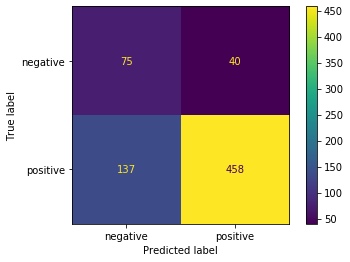

In [34]:
# Initiate the model
dt = DecisionTreeClassifier(random_state=42)  

# Fit the model and get predictions
dt_Xy = train_and_predict(dt, Xy)

# Evaluate model
model_scores(dt, dt_Xy)

Summary: Improvement again to predicting negative class, however it is at a sacrifice to predicting positive class.

## Model 2b - Decision Tree Classifier Grid Search

Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: 9
min_samples_leaf: 2
min_samples_split: 5
Training Accuracy: 73.9%
Test Accuracy: 61.41%

Training F1 Score: 76.99%
Test F1 Score: 33.5%

Confusion Matrix for test data


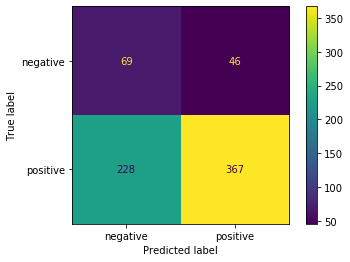

In [35]:
# define parameters to search
params_dt = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(2,10),
    'min_samples_split':range(2,10),
    'min_samples_leaf':range(2,5)
    }

# run grid search
(dt_gs, dt_gs_Xy) = run_grid_search(params_dt, dt, Xy)

# Evaluate model
model_scores(dt_gs, dt_gs_Xy)

Summary: Worse performance overall. 

## Model 3 - XG Boost

Trying out a gradient boosted model.

Training Accuracy: 82.42%
Test Accuracy: 71.97%

Training F1 Score: 83.68%
Test F1 Score: 41.3%

Confusion Matrix for test data


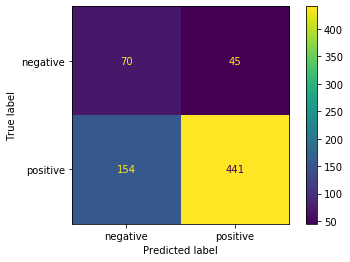

In [36]:
# Initiate the model
xgb = XGBClassifier(random_state=42)

# Fit the model and get predictions
xgb_Xy = train_and_predict(xgb, Xy)

# Evaluate model
model_scores(xgb, xgb_Xy)

Summary: Performance about the same as Model 2b.

## Model 3b - Grid Search with XG Boost

Use a grid search in connection with XG Boost to get better performance.

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 4
min_child_weight: 2
n_estimators: 20
scale_pos_weight: 6
subsample: 0.8
Training Accuracy: 54.18%
Test Accuracy: 84.93%

Training F1 Score: 15.55%
Test F1 Score: 13.01%

Confusion Matrix for test data


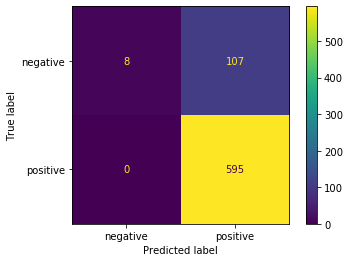

In [37]:
# define parameters to search
xgb_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4],
    'min_child_weight': [1, 2],
    'subsample': [0.7, 0.8],
    'n_estimators': [10, 20],
    'scale_pos_weight': [6] # impose greater penalties for errors on the minor class, sum(negative instances) / sum(positive instances)
    }

# run grid search
(xgb_gs, xgb_gs_Xy) = run_grid_search(xgb_params, xgb, Xy)

# Evaluate model
model_scores(xgb_gs, xgb_gs_Xy)

Summary: Not a suitable model.

### Feature Importance
Look at top influential features for the Linear Regression model.

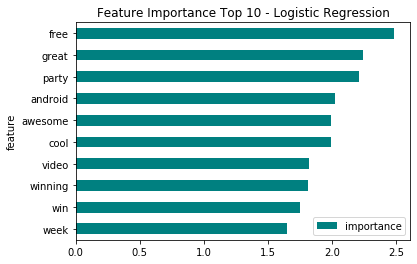

In [78]:
# get importance
feature_names = Xy.X_train.columns

# create dataframe of top 10 features
feature_importance = pd.DataFrame(feature_names, columns = ['feature'])
feature_importance['importance'] = logreg.coef_[0]
feature_importance = feature_importance.sort_values(by = ['importance'], ascending=False)

# plot importance
ax = feature_importance.iloc[:10].plot.barh(x='feature', y='importance', color='teal').invert_yaxis()
plt.title('Feature Importance Top 10 - Logistic Regression')
plt.show()

### Conclusion
#### Results
For the business purpose, it is the most useful to identify a positive or negative sentiment as a neutral sentiment does not give us additional information about a project. Based on this, the selected model is the grid-seached logistic regression model (Model 1b). The reason for choosing this mode is that it can predict positive sentiments better than other models, while achieving about the same negative predictions as than the other models. This is reflected by the f1 scores and confusion matrices for the test data. The other models had reduced ability to identify positive cases while only slightly better performing with the negative cases.

#### Recommendations
Based on these findings, it is recommended that:
1. Tweets can be analyzed via machine learning to capture sentiments
2. The model should be periodically retrained with new data to improve results, especially for the negative class
3. The top words give a variety of insight into why people are posting tweets in the first place. For example "free" could indicate the occasstion to tweet about a product, while "great" is how a tweeter feels. One interpretation could be one could encourage reviews by giving out free products. 